In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import hydromt

from pathlib import Path
from hydromt_sfincs import SfincsModel
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Define your custom colors for floodmaps
colors = ['grey', 'white', 'lightblue', 'blue']
cmap = ListedColormap(colors)
bounds = np.array([-1.5, -0.5, 0.5, 1.5, 2.5])
norm = BoundaryNorm(bounds, cmap.N)

### Models
Load all models and results and add them to a dictionary:

In [3]:
model_names = os.listdir(Path("model"))
models = {}
results = {}
for model_name in model_names:
    model = SfincsModel(fr"model/{model_name}/", mode="r")
    model.read_results()
    
    models[model_name] = model
    results[model_name] = model.results

In [4]:
# We append 1 model as the base model, with a representative grid.
mod0 = models["garissa_depth3m_fabdem_grid100"]

### Flood maps
Load and plot the available flood maps:

In [5]:
# Available floodmaps
floodmap_names = {
"opera":[
    "2023-10-12",
    "2023-11-11",
    "2023-11-21",
    "2023-11-29",
],
"unosat":[
    "2023-11-26",
    "2023-12-01",
]}
print(floodmap_names)

{'opera': ['2023-10-12', '2023-11-11', '2023-11-21', '2023-11-29'], 'unosat': ['2023-11-26', '2023-12-01']}


In [17]:
# Each dataset has its own defined conventions, so we need to pre-process the data
# clouds:-1, no water:0, permanent water:1, flood:2.
data_map = {
    "opera":{
        "2023-10-12":{-4:1, 1:1},
        "2023-11-11":{-4:1, 1:1, -3:-1},
        "2023-11-21":{-4:1, 1:1, -3:-1},
        "2023-11-29":{-3:-1, -1:-1, 1:1},
    },
    "unosat":{
        "2023-11-26":{},
        "2023-12-01":{},
    }
}

def map_values(map, array):
    for i in range(array.data.shape[0]):
        for j in range(array.data.shape[1]):

            if array.data[i,j] in map.keys():
                array.data[i,j] = map[array.data[i,j]]
                
    return array

In [18]:
analysis_extent_path = Path(r"data/2_floodmaps/analysis_extent_garissa.shp")
analysis_extent = gpd.read_file(analysis_extent_path)

### Raster floodmap
OPERA has a raster format.

(array([0, 1], dtype=int8), array([50699,   574], dtype=int64))
(array([-1,  0,  1], dtype=int8), array([35895, 13166,  2212], dtype=int64))
(array([-1,  0,  1], dtype=int8), array([12364, 33143,  5766], dtype=int64))
(array([-1,  0,  1], dtype=int8), array([11363, 35548,  4362], dtype=int64))


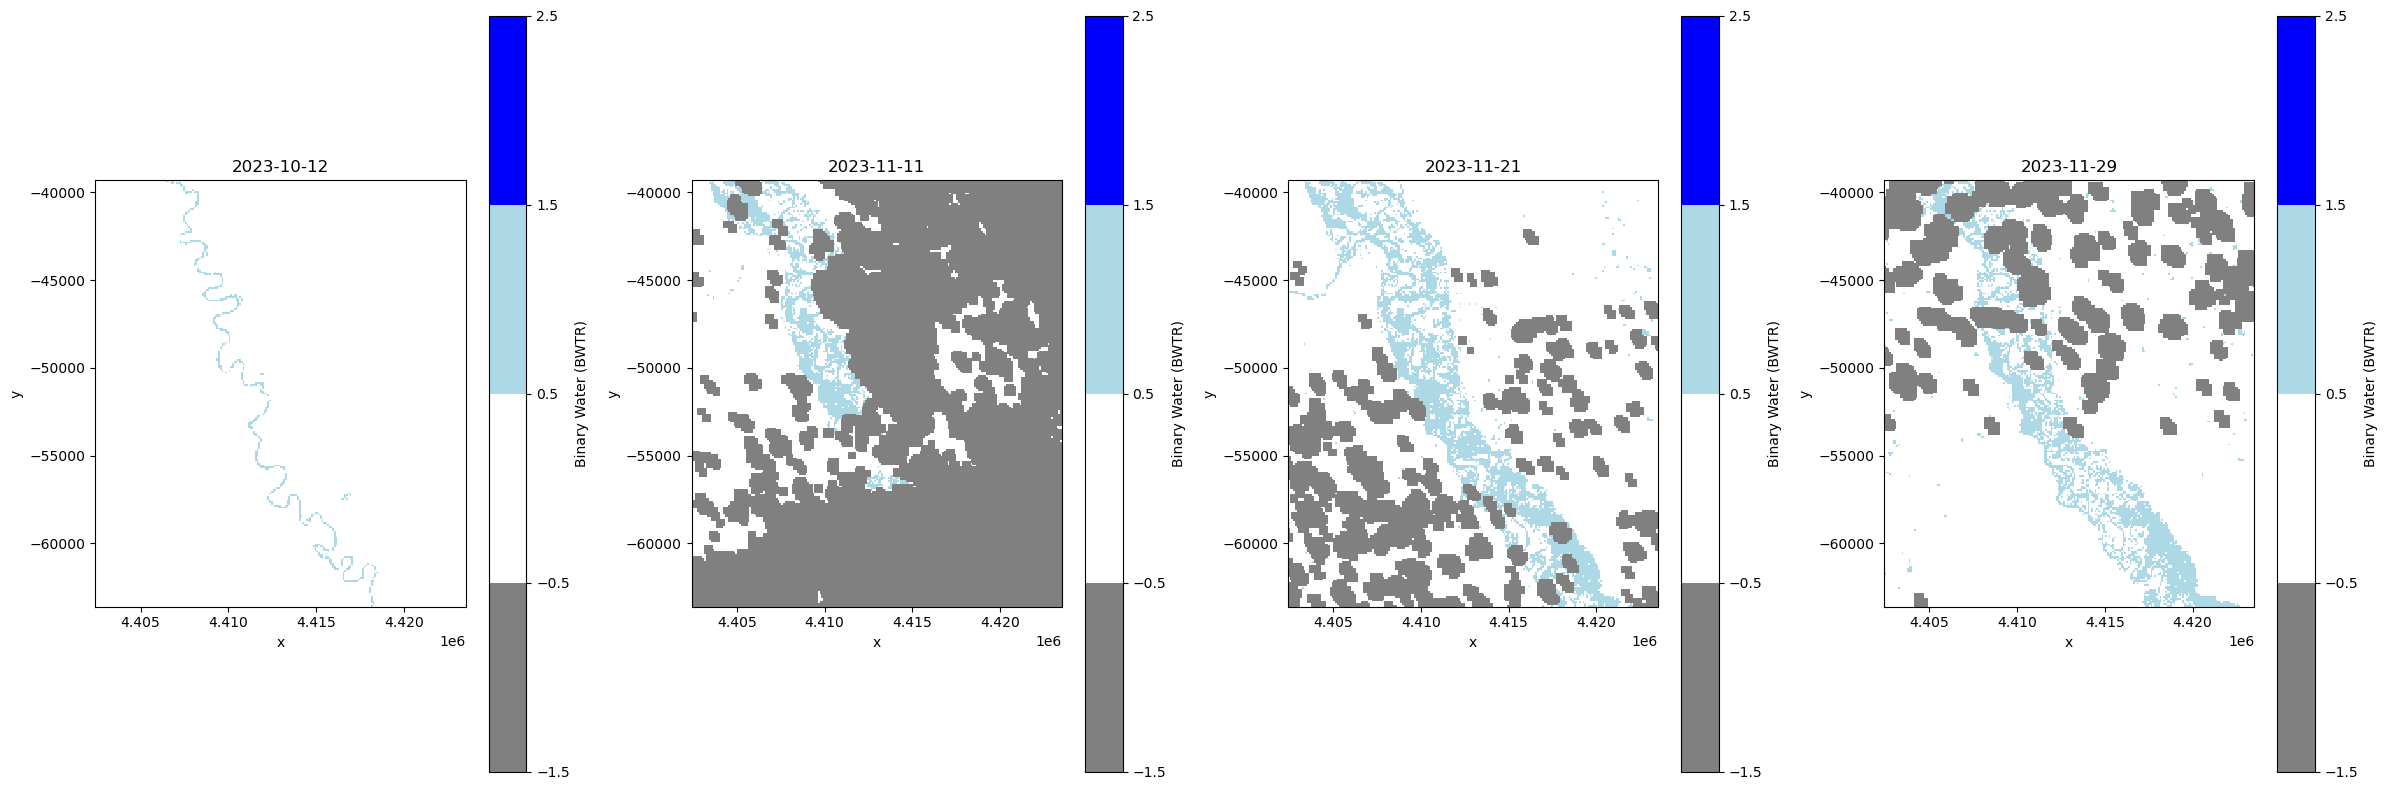

In [19]:
fig, axs = plt.subplots(1,4, figsize=(24, 8))
i= 0

floodmaps = {}

for date in floodmap_names["opera"]:
    path = Path(f"data/2_floodmaps/opera/{date}/floodmap.tif")

    # First, we open the flood map and convert it to the datatype we want.
    floodmap = hydromt.open_raster(path).load().astype(np.int8)
    floodmap.raster.set_spatial_dims(x_dim="x", y_dim="y")
    floodmap = floodmap.raster.reproject_like(mod0.grid, method='nearest')

    # Now, we re-map the data to the wanted values.
    floodmap = map_values(data_map["opera"][date], floodmap)

    # We save the new raster.
    floodmap.raster.to_raster(Path(f"data/2_floodmaps/reprojected_maps/opera_{date}.tif"))
    floodmaps[f"opera_{date}"] = floodmap

    floodmap.plot(ax=axs[i], cmap=cmap, norm=norm)
    axs[i].set_title(date)
    axs[i].axis("scaled")   
    i+=1

plt.tight_layout()
plt.show()

### Vector floodmap
UNOSAT has a vector format. Sentinel-2 image was acquired on 26 November 2023 at 10:50 local time. Observation time on 1 December 2023 is unknown.

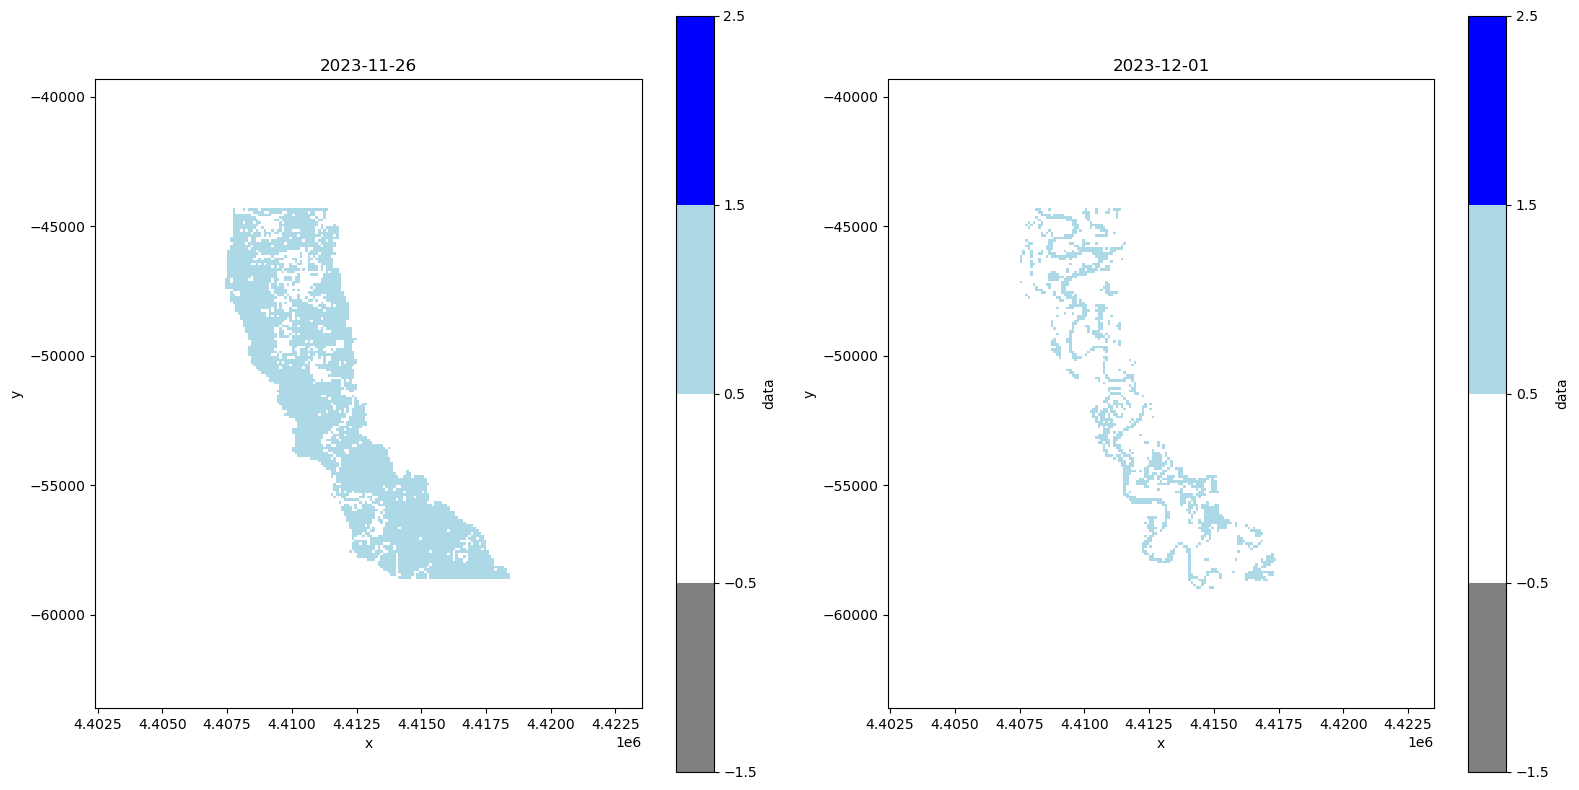

In [10]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))
i= 0

for date in floodmap_names["unosat"]:
    path = Path(f"data/2_floodmaps/unosat/{date}/floodmap_raster_qgis.tif")
    
    floodmap = hydromt.open_raster(path).load().astype(np.int8)
    floodmap.raster.set_spatial_dims(x_dim="x", y_dim="y")
    floodmap = floodmap.raster.reproject_like(mod0.grid, method='nearest')
    floodmap.raster.to_raster(Path(f"data/2_floodmaps/reprojected_maps/unosat_{date}.tif"))

    floodmaps[f"unosat_{date}"] = floodmap

    floodmap.plot(ax=axs[i], cmap=cmap, norm=norm)
    axs[i].set_title(date)
    axs[i].axis("scaled")   
    i+=1

plt.tight_layout()
plt.show()